In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


/u/f/fcaretti/miniforge3/envs/bioenv/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/u/f/fcaretti/miniforge3/envs/bioenv/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


# Introduction to VAEs
Variational Autoencoders are, in practice, the most common form of Black Box Variational Inference (BBVI). Here we will only look at them from a practical point of view. In particular, we will stress the differences with normal autoencoders, mainly used for dimensionality reduction.

## Normal Autoencoders

In [8]:
class ConvAutoencoder_MNIST(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_MNIST, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Output: 32 x 7 x 7
            nn.ReLU(True),
            nn.Flatten(),  # Flatten for the linear layers
            nn.Linear(32 * 7 * 7, 10)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),  # Unflatten to 32 x 7 x 7
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Output: 1 x 28 x 28
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z
    
#function to show mnist images, after they are imported with the following normalization
def imshow_mnist(img):
    mean = 0.1307
    std = 0.3081
    img = img.numpy() 
    img = std * img + mean  
    img = np.clip(img, 0, 1)  
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()


In [12]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, range(10000))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(1000))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and the optimizer
AE_mnist = ConvAutoencoder_MNIST().to(device)
optimizer = torch.optim.SGD(AE_mnist.parameters(), lr=0.00001, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

In [13]:
# Train the Autoencoder
n_epochs = 5
for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), 1, 28, 28).to(device)
        # Forward pass
        output, _ = AE_mnist(img)
        loss = criterion(output, img)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    AE_mnist.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader_2:
            img.to(device)
            img = img.view(img.size(0), 1, 28, 28).to(device)
            train_output,_ = AE_mnist(img)
            train_loss += criterion(train_output, img).item()/img.size(0)           
    train_loss /= (len(train_loader_2)*28*28)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            img.to(device)  
            img = img.view(img.size(0), 1, 28, 28).to(device)
            test_output,_ = AE_mnist(img)
            test_loss += criterion(test_output, img).item()/img.size(0)
    test_loss /= (len(test_loader)*28*28)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/5 - Train Loss: 0.39290178571428575, Test Loss: 0.3940206289291382
Epoch 2/5 - Train Loss: 0.31866501913265305, Test Loss: 0.3176899968361368
Epoch 3/5 - Train Loss: 0.32955669642857144, Test Loss: 0.3277280177388872
Epoch 4/5 - Train Loss: 0.2781143494897959, Test Loss: 0.28449650783928077
Epoch 5/5 - Train Loss: 0.2720224808673469, Test Loss: 0.27514981469329525


In [14]:
#after training, put back the network in the cpu
AE_mnist.to('cpu')

ConvAutoencoder_MNIST(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1568, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

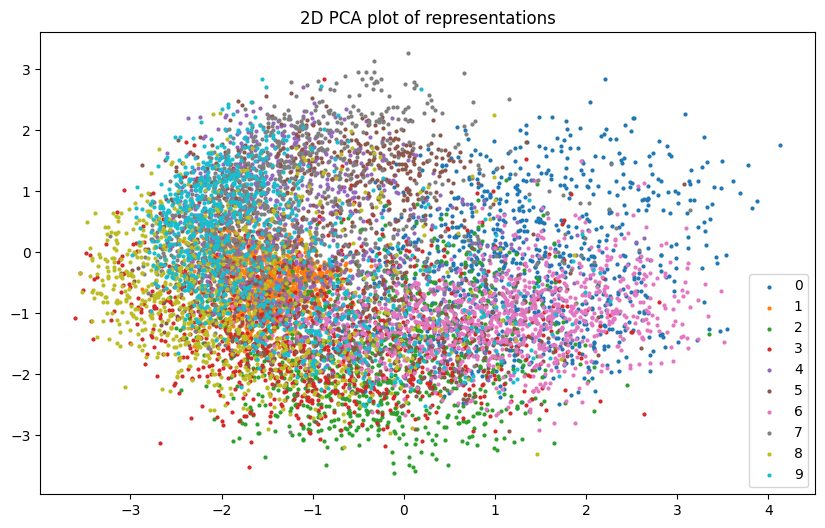

In [19]:
#in this case it doesn't change much, but it's good practice to set the model to evaluation mode after training
AE_mnist.eval()
with torch.no_grad():
    # Get a batch of data and put it through the network
    images, labels = next(iter(train_loader_2))
    images = images.view(images.size(0), 1, 28, 28)
    _, representations = AE_mnist(images)


#plot the representations in 2D using PCA, colored by class label
pca = PCA(n_components=2)
representations_2d = pca.fit_transform(representations)
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations_2d[indices, 0], representations_2d[indices, 1], label=str(i), alpha=1, s=4)
plt.legend()
plt.title('2D PCA plot of representations')
plt.show()


In [20]:
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison

AE_mnist.eval() 
with torch.no_grad():  
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE_mnist(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format

Original Images


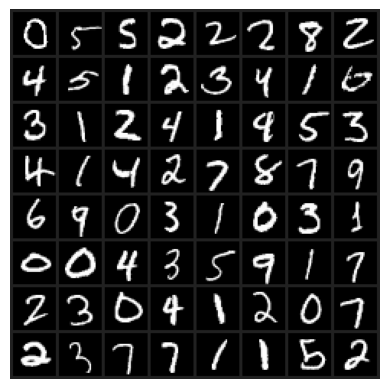

Reconstructed Images


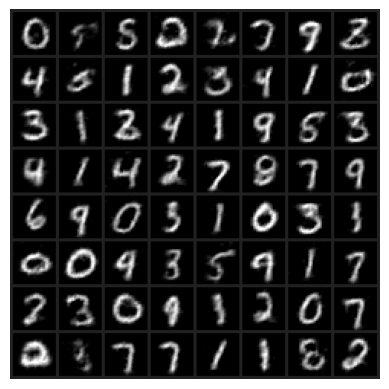

In [21]:
# Display original images
print("Original Images")
imshow_mnist(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(reconstructed))
plt.show()

Reconstructed Images


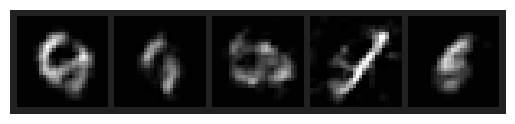

In [111]:
#how to "sample" from the latent space?
#generate random numbers from a normal distribution
#feed them through the decoder

latent_space_samples = torch.randn(5, 10)
output = AE_mnist.decoder(latent_space_samples)
output = output.view(-1, 1, 28, 28)

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(output))
plt.show()

tensor([2, 1, 7, 9, 9, 3, 1, 1, 2, 8])


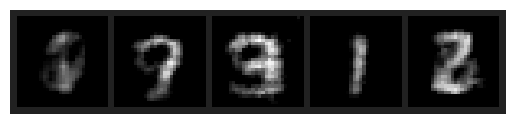

In [112]:
#feed 10 images in the encoder and get the latent representations
# Get a batch of test images
images, labels = next(iter(test_loader))
original_images = images  # Save the original images for comparison

print(labels[:10])
AE_mnist.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE_mnist(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    reconstructed = reconstructed[:10]

pair_means = []
for i in range(0, len(reconstructed), 2):  # Step by 2
    if i+1 < len(reconstructed):  # Check if there is a pair
        mean_img = 0.5 * (reconstructed[i] + reconstructed[i+1])  # Calculate the mean
        pair_means.append(mean_img)

imshow_mnist(torchvision.utils.make_grid(pair_means))

## Ok, now let's try to do the same with a VAE!

In [23]:
#this needs two big modifications: one in the actual model, and one in the loss function

class ConvVAE_MNIST(nn.Module):
    def __init__(self):
        super(ConvVAE_MNIST, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.get_mu = nn.Linear(32 * 7 * 7, 10)
        self.get_logvar = nn.Linear(32 * 7 * 7, 10)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.get_mu(encoded)
        logvar = self.get_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [142]:
VAE_mnist = ConvVAE_MNIST()
optimizer = torch.optim.SGD(VAE_mnist.parameters(), lr=0.00001, weight_decay=1e-5, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

In [143]:
n_epochs = 5

# Calculate training loss over the entire training set
train_loss = 0
with torch.no_grad():  # No need to track gradients
    for img,_ in train_loader:
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        train_output, mu, logvar = VAE_mnist(img)
        train_loss += ((criterion(train_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))           
train_loss /= (len(train_loader)*28*28)
print(f'Initial Train Loss: {train_loss}')

for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        # Forward pass
        output, mu, logvar = VAE_mnist(img)
        loss = criterion(output, img)+kl_divergence(mu, logvar)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    VAE_mnist.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader_2:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            train_output, mu, logvar = VAE_mnist(img)
            train_loss += ((criterion(train_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))           
    train_loss /= (len(train_loader_2)*28*28)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            test_output, mu, logvar = VAE_mnist(img)
            test_loss += ((criterion(test_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))
    test_loss /= (len(test_loader)*28*28)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Initial Train Loss: 1.036620670280422
Epoch 1/5 - Train Loss: 0.7592290178571428, Test Loss: 0.7354101151836162
Epoch 2/5 - Train Loss: 0.4132466836734694, Test Loss: 0.4119849774302269
Epoch 3/5 - Train Loss: 0.39256342474489797, Test Loss: 0.3877541318231699
Epoch 4/5 - Train Loss: 0.3408045918367347, Test Loss: 0.3459367294700778
Epoch 5/5 - Train Loss: 0.3352737882653061, Test Loss: 0.3406781921581346


In [ ]:
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison


VAE_mnist.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    #images = images.view(images.size(0), -1)
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, mu, logvar = AE_mnist(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format

Original Images


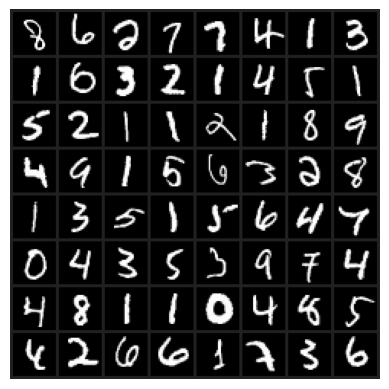

Reconstructed Images


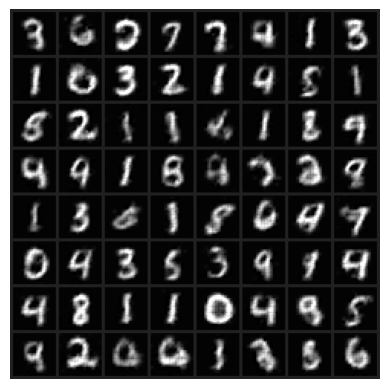

In [146]:
# Display original images
print("Original Images")
imshow_mnist(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(reconstructed))
plt.show()

In [144]:
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison


VAE_mnist.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    #images = images.view(images.size(0), -1)
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, mu, logvar = VAE_mnist(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    print(latent.shape)

torch.Size([64, 10])


Original Images


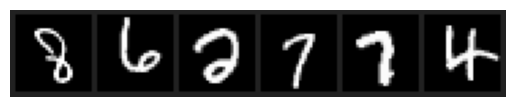

Reconstructed Images


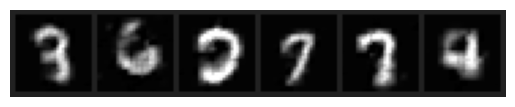

In [145]:
# Number of images to display
num_images = 6

# Display original images
print("Original Images")
imshow_mnist(torchvision.utils.make_grid(original_images[:num_images]))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(reconstructed[:num_images]))
plt.show()

In [130]:
VAE_mnist.eval()
with torch.no_grad():
    # Get a batch of data
    images, labels = next(iter(train_loader_2))
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    #images = images.view(images.size(0), -1)
    # Forward pass through the encoder
    _, representations, _ = VAE_mnist(images)

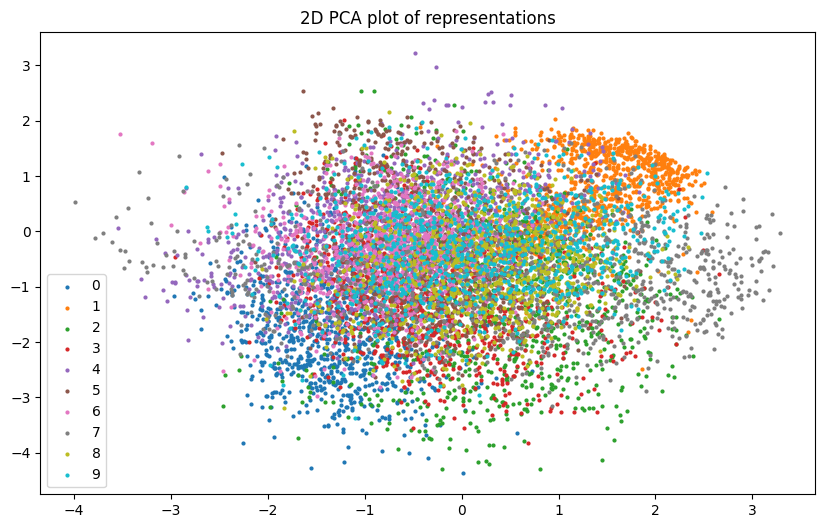

In [131]:
#do PCA instead
pca = PCA(n_components=2)
representations_2d = pca.fit_transform(representations)
representations_2d = representations[:, :2].numpy()
# Plot the resulting points
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations_2d[indices, 0], representations_2d[indices, 1], label=str(i), alpha=1, s=4)
plt.legend()
plt.title('2D PCA plot of representations')
plt.show()

Reconstructed Images


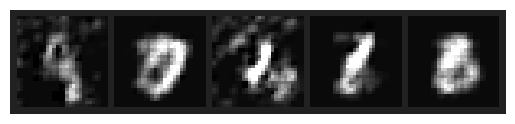

In [132]:
#generate random numbers from a normal distribution
#feed them through the decoder

latent_space_samples = torch.randn(5, 10)
output = VAE_mnist.decoder(VAE_mnist.decoder_fc(latent_space_samples))
output = output.view(-1, 1, 28, 28)

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(output))
plt.show()

tensor([7, 8, 0, 5, 3, 6, 2, 6, 2, 0])
torch.Size([10, 1, 28, 28])


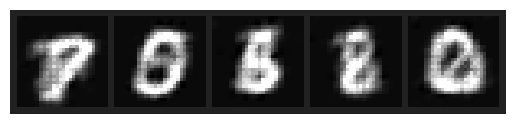

In [133]:
#feed 10 images in the encoder and get the latent representations
# Get a batch of test images
images, labels = next(iter(test_loader))
original_images = images  # Save the original images for comparison

print(labels[:10])
VAE_mnist.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, _, _ = VAE_mnist(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    reconstructed = reconstructed[:10]
    print(reconstructed.shape)

pair_means = []
for i in range(0, len(reconstructed), 2):  # Step by 2
    if i+1 < len(reconstructed):  # Check if there is a pair
        mean_img = 0.5 * (reconstructed[i] + reconstructed[i+1])  # Calculate the mean
        pair_means.append(mean_img)

imshow_mnist(torchvision.utils.make_grid(pair_means))

## Let's get fancier, and move to CIFAR10
### Please notice: run the following code only if you have a GPU available

In [63]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # Output: 64 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),# Output: 128 x 4 x 4
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, 128)
        self.fc_logvar = nn.Linear(128 * 4 * 4, 128)

        # Decoder
        self.decoder_fc = nn.Linear(128, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_fc(z)), mu, logvar

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Selecting only two classes, planes (0) and cats (3)
class_indices = [0,3]
indices = [i for i, (_, label) in enumerate(train_dataset) if label in class_indices]
subset_train_dataset = torch.utils.data.Subset(train_dataset, indices)

test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in class_indices]
subset_test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(subset_test_dataset, batch_size=len(test_dataset), shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
VAE = ConvVAE().to(device)
optimizer = torch.optim.Adam(VAE.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='sum')

n_epochs = 40
for epoch in range(n_epochs):
    VAE.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = VAE(images)
        reconstruction_loss = criterion(reconstructed, images)
        kl_loss = kl_divergence(mu, logvar)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()

    # Evaluation phase
    VAE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for images,_ in train_loader:
            images = images.to(device)
            train_output, mu, logvar = VAE(images)
            train_loss += ((criterion(train_output, images)+kl_divergence(mu,logvar)).item()/images.size(0))           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for images,_ in test_loader:
            images = images.to(device)
            test_output, mu, logvar = VAE(images)
            test_loss += ((criterion(test_output, images)+kl_divergence(mu,logvar)).item()/images.size(0))
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')
        

Epoch 1/40 - Train Loss: 1153.5206909179688, Test Loss: 1147.71575
Epoch 2/40 - Train Loss: 787.3848219950488, Test Loss: 785.7265
Epoch 3/40 - Train Loss: 696.4131236471188, Test Loss: 695.5379375
Epoch 4/40 - Train Loss: 632.2287263323547, Test Loss: 634.5750625
Epoch 5/40 - Train Loss: 592.7584314042596, Test Loss: 596.473625
Epoch 6/40 - Train Loss: 574.8693598850517, Test Loss: 578.2735625
Epoch 7/40 - Train Loss: 553.8251509939789, Test Loss: 557.9958125
Epoch 8/40 - Train Loss: 532.7737947694815, Test Loss: 537.326625
Epoch 9/40 - Train Loss: 524.24017100729, Test Loss: 530.689875
Epoch 10/40 - Train Loss: 524.0231634249353, Test Loss: 530.5358125
Epoch 11/40 - Train Loss: 511.6462392624776, Test Loss: 518.185
Epoch 12/40 - Train Loss: 496.96616786300757, Test Loss: 505.5856875
Epoch 13/40 - Train Loss: 499.09572411798365, Test Loss: 508.05065625
Epoch 14/40 - Train Loss: 562.7118773247786, Test Loss: 573.7501875
Epoch 15/40 - Train Loss: 479.6803211770999, Test Loss: 489.282062

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
def imshow_cifar10(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    img = img.numpy()
    img = std[:, None, None] * img + mean[:, None, None]  # Unnormalize
    img = np.transpose(img, (1, 2, 0))  # Rearrange dimensions to HWC for plotting
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


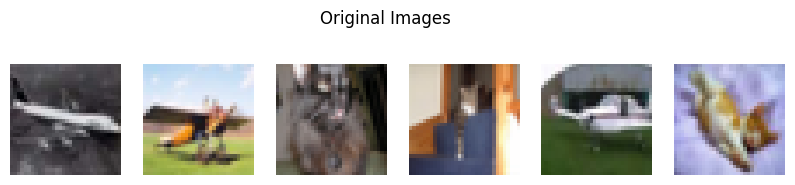

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


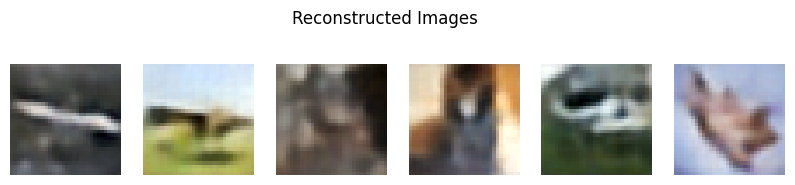

In [76]:
# Get a batch of images from the test set
images, _ = next(iter(train_loader))
images = images.to(device)

# Forward pass through VAE
VAE.eval()
with torch.no_grad():
    reconstructed, mu_z, _ = VAE(images)

# Compare original and reconstructed images
images = images.cpu()
reconstructed = reconstructed.cpu()

# Display original images
plt.figure(figsize=(10, 4))
plt.suptitle('Original Images')
for i in range(6):
    plt.subplot(2, 6, i+1)
    imshow_cifar10(torchvision.utils.make_grid(images[i]))
plt.show()

# Display reconstructed images
plt.figure(figsize=(10, 4))
plt.suptitle('Reconstructed Images')
for i in range(6):
    plt.subplot(2, 6, i+1)
    imshow_cifar10(torchvision.utils.make_grid(reconstructed[i]))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


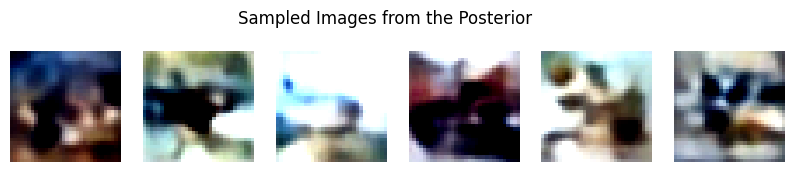

In [77]:
# Generate and display images from the latent space
num_samples = 6
z = torch.randn(num_samples, 128) # Randomly sample latent variables
VAE.to('cpu')

with torch.no_grad():
    z_linear = VAE.decoder_fc(z)
    sampled_images = VAE.decoder(z_linear)

plt.figure(figsize=(10, 2))
plt.suptitle('Sampled Images from the Posterior')
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    imshow(torchvision.utils.make_grid(sampled_images[i]))
plt.show()